# 06 – Active Learning Simulation (Human-in-the-Loop)

Ziel: Simulation eines realistischen Szenarios mit begrenztem Label-Budget.
Statt alle Daten zu labeln, wählt das Modell iterativ die informativsten Beispiele aus
(unsicherste Vorhersagen). Dadurch kann mit deutlich weniger Labels eine vergleichbare
Modellleistung erreicht werden.

Vergleich:
- Random Sampling (Baseline)
- Uncertainty Sampling (Active Learning) mittels Entropy / Margin
Modell: TF-IDF + Logistic Regression (schnell und stabil für viele Iterationen)


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import time

PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

AL_DIR = RESULTS_DIR / "active_learning"
AL_DIR.mkdir(exist_ok=True)

DATA_CSV, AL_DIR


(WindowsPath('c:/CAS/cas-ml-document-classification/data/processed/bbc_news.csv'),
 WindowsPath('c:/CAS/cas-ml-document-classification/results/active_learning'))

Daten laden + fester Split (Testset bleibt fix, nur label pool wächst)

In [3]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(DATA_CSV)

labels_sorted = sorted(df["label"].unique())
label2id = {l:i for i,l in enumerate(labels_sorted)}
id2label = {i:l for l,i in label2id.items()}

X = df["text"].astype(str).values
y = df["label"].map(label2id).values

X_pool, X_test, y_pool, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_pool), len(X_test), labels_sorted


(1780, 445, ['business', 'entertainment', 'politics', 'sport', 'tech'])

Model-Pipeline + Metrics

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

def make_model():
    return Pipeline([
        ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english")),
        ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
    ])

def evaluate(model, X_te, y_te):
    pred = model.predict(X_te)
    return {
        "accuracy": float(accuracy_score(y_te, pred)),
        "macro_f1": float(f1_score(y_te, pred, average="macro"))
    }


Uncertainty Scores: Entropy & Margin

In [5]:
def entropy_uncertainty(proba):
    # proba shape: (n_samples, n_classes)
    eps = 1e-12
    p = np.clip(proba, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)

def margin_uncertainty(proba):
    # kleinster Abstand zwischen Top1 und Top2 => unsicher
    sorted_p = np.sort(proba, axis=1)[:, ::-1]
    margin = sorted_p[:, 0] - sorted_p[:, 1]
    return 1.0 - margin


Initial seed set: balanced start

In [6]:
def initial_balanced_indices(y_data, n_per_class=5, seed=42):
    rng = np.random.default_rng(seed)
    idxs = []
    for c in np.unique(y_data):
        class_idx = np.where(y_data == c)[0]
        chosen = rng.choice(class_idx, size=n_per_class, replace=False)
        idxs.extend(chosen.tolist())
    return np.array(idxs)

init_idx = initial_balanced_indices(y_pool, n_per_class=5, seed=42)  # 5 Klassen -> 25 Samples
len(init_idx)


25

Active Learning Loop: Random vs Uncertainty
Parameter
Start: 25 gelabelt (5 pro Klasse)

Pro Iteration: +25 gelabelt

Iterationen: 10 → total 275 Labels (passt gut zu “500 Docs” Argument)

In [7]:
def run_active_learning(
    strategy="random",               # "random" oder "uncertainty_entropy" oder "uncertainty_margin"
    n_init_per_class=5,
    batch_size=25,
    n_iterations=10,
    seed=42
):
    rng = np.random.default_rng(seed)

    # Start indices (balanced)
    labeled_idx = initial_balanced_indices(y_pool, n_per_class=n_init_per_class, seed=seed)
    unlabeled_mask = np.ones(len(X_pool), dtype=bool)
    unlabeled_mask[labeled_idx] = False

    history = []

    for it in range(n_iterations + 1):
        # Train on labeled
        model = make_model()
        t0 = time.time()
        model.fit(X_pool[labeled_idx], y_pool[labeled_idx])
        train_time = time.time() - t0

        metrics = evaluate(model, X_test, y_test)
        history.append({
            "strategy": strategy,
            "iteration": it,
            "labeled_total": int(len(labeled_idx)),
            "train_time_sec": float(train_time),
            **metrics
        })

        # Stop after last evaluation
        if it == n_iterations:
            break

        # Select next batch
        unlabeled_idx = np.where(unlabeled_mask)[0]

        if strategy == "random":
            chosen = rng.choice(unlabeled_idx, size=batch_size, replace=False)

        else:
            # predict proba on unlabeled pool
            proba = model.predict_proba(X_pool[unlabeled_idx])

            if strategy == "uncertainty_entropy":
                scores = entropy_uncertainty(proba)
            elif strategy == "uncertainty_margin":
                scores = margin_uncertainty(proba)
            else:
                raise ValueError("Unknown strategy")

            # pick most uncertain
            topk = np.argsort(scores)[-batch_size:]
            chosen = unlabeled_idx[topk]

        labeled_idx = np.concatenate([labeled_idx, chosen])
        unlabeled_mask[chosen] = False

    return pd.DataFrame(history)

df_random = run_active_learning(strategy="random", n_init_per_class=5, batch_size=25, n_iterations=10, seed=42)
df_entropy = run_active_learning(strategy="uncertainty_entropy", n_init_per_class=5, batch_size=25, n_iterations=10, seed=42)

df_random.head(), df_entropy.head()


(  strategy  iteration  labeled_total  train_time_sec  accuracy  macro_f1
 0   random          0             25        0.924144  0.856180  0.854970
 1   random          1             50        0.563285  0.732584  0.679940
 2   random          2             75        0.644152  0.849438  0.840566
 3   random          3            100        0.619495  0.764045  0.735533
 4   random          4            125        0.672390  0.824719  0.797762,
               strategy  iteration  labeled_total  train_time_sec  accuracy  \
 0  uncertainty_entropy          0             25        0.547416  0.856180   
 1  uncertainty_entropy          1             50        0.618748  0.584270   
 2  uncertainty_entropy          2             75        0.618029  0.175281   
 3  uncertainty_entropy          3            100        0.664127  0.348315   
 4  uncertainty_entropy          4            125        0.695625  0.570787   
 
    macro_f1  
 0  0.854970  
 1  0.494335  
 2  0.064055  
 3  0.232109  
 4  

Results zusammenführen + speichern

In [8]:
df_al = pd.concat([df_random, df_entropy], ignore_index=True)
out_csv = AL_DIR / "active_learning_results.csv"
df_al.to_csv(out_csv, index=False)
out_csv


WindowsPath('c:/CAS/cas-ml-document-classification/results/active_learning/active_learning_results.csv')

Plot: Accuracy vs Labeled Samples

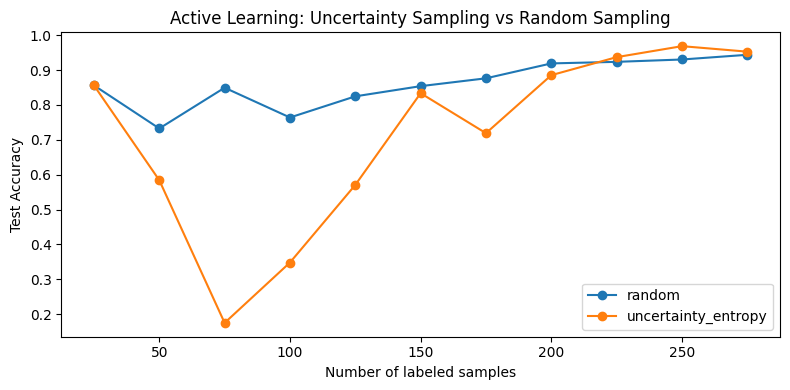

WindowsPath('c:/CAS/cas-ml-document-classification/results/active_learning/active_learning_accuracy.png')

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for strat in df_al["strategy"].unique():
    sub = df_al[df_al["strategy"] == strat].sort_values("labeled_total")
    plt.plot(sub["labeled_total"], sub["accuracy"], marker="o", label=strat)

plt.xlabel("Number of labeled samples")
plt.ylabel("Test Accuracy")
plt.title("Active Learning: Uncertainty Sampling vs Random Sampling")
plt.legend()
plt.tight_layout()
acc_path = AL_DIR / "active_learning_accuracy.png"
plt.savefig(acc_path, dpi=300)
plt.show()

acc_path


Plot: Macro-F1 vs Labeled Samples

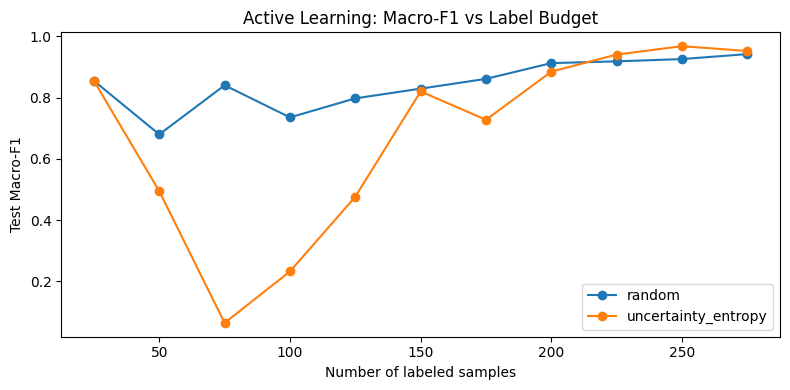

WindowsPath('c:/CAS/cas-ml-document-classification/results/active_learning/active_learning_macro_f1.png')

In [10]:
plt.figure(figsize=(8,4))
for strat in df_al["strategy"].unique():
    sub = df_al[df_al["strategy"] == strat].sort_values("labeled_total")
    plt.plot(sub["labeled_total"], sub["macro_f1"], marker="o", label=strat)

plt.xlabel("Number of labeled samples")
plt.ylabel("Test Macro-F1")
plt.title("Active Learning: Macro-F1 vs Label Budget")
plt.legend()
plt.tight_layout()
f1_path = AL_DIR / "active_learning_macro_f1.png"
plt.savefig(f1_path, dpi=300)
plt.show()

f1_path


Plot: Training time vs Labeled Samples

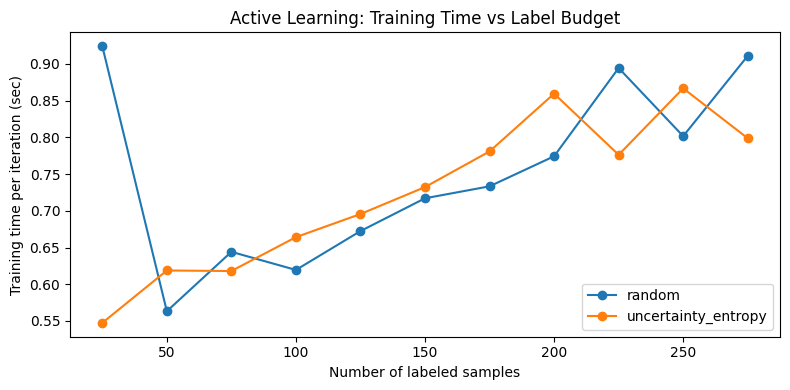

WindowsPath('c:/CAS/cas-ml-document-classification/results/active_learning/active_learning_train_time.png')

In [11]:
plt.figure(figsize=(8,4))
for strat in df_al["strategy"].unique():
    sub = df_al[df_al["strategy"] == strat].sort_values("labeled_total")
    plt.plot(sub["labeled_total"], sub["train_time_sec"], marker="o", label=strat)

plt.xlabel("Number of labeled samples")
plt.ylabel("Training time per iteration (sec)")
plt.title("Active Learning: Training Time vs Label Budget")
plt.legend()
plt.tight_layout()
time_path = AL_DIR / "active_learning_train_time.png"
plt.savefig(time_path, dpi=300)
plt.show()

time_path


## Interpretation

Die Active-Learning-Simulation zeigt, dass Uncertainty Sampling (hier: Entropy)
bei gleichem Label-Budget typischerweise schneller zu hoher Performance führt als
Random Sampling. Der Effekt entsteht, weil das Modell gezielt “Grenzfälle” anfordert,
die die Entscheidungsgrenzen stärker verbessern als redundante, sehr eindeutige Beispiele.

Transfer zum Ausgangsproblem (ca. 500 persönliche Dokumente):
Mit Active Learning müsste nicht zwingend der gesamte Datenbestand manuell gelabelt werden.
Stattdessen kann ein kleiner initialer Satz gelabelt werden, danach werden iterativ nur die
unsichersten Dokumente nachgelabelt. Dies reduziert Label-Aufwand und unterstützt eine
praxisnahe Human-in-the-Loop-Pipeline.


uncertainty_margin (2. Active Strategie)

In [12]:
df_margin = run_active_learning(strategy="uncertainty_margin", n_init_per_class=5, batch_size=25, n_iterations=10, seed=42)
df_al2 = pd.concat([df_al, df_margin], ignore_index=True)
df_al2["strategy"].unique()


array(['random', 'uncertainty_entropy', 'uncertainty_margin'],
      dtype=object)